<br> </br>
<font size = 8> <center> AI Strategy and Digital transformation </center> </font>
<font size = 6> <center>  <b> 8. Workshop with pycaret </b> </center>
<br>
<font size = 5> <center> Piotr Wójcik </center> </font>
<font size = 5> <center> University of Warsaw, Poland
<font size = 5> <center> pwojcik@wne.uw.edu.pl
<br> </br>
<font size = 5> <center>  January 2025 </center> </font>
</center> </font>

In [ ]:
# change working directory
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/szkolenia/2025-01_Bucharest'

# see the tutorial here: https://www.pycaret.org/tutorials/html/CLF101.html

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/szkolenia/2025-01_Bucharest


In [ ]:
# you may have to run this first
# pip install pycaret[analysis]
# pip install shap

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
# from pycaret import classification
import pycaret
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, recall_score, precision_score, f1_score, get_scorer, make_scorer # to define own metrics
from pycaret.classification import *
import shap
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# lets load the original churn data
churn = pd.read_csv("data/churn.csv")

# random split into train (70%)/test (30%) stratified by 'account_status'
churn_train, churn_test = train_test_split(
    churn,
    test_size = 0.3,
    stratify = churn['account_status'],
    random_state = 123
)

churn_test.head()

,customer_id,customer_age,customer_gender,customer_number_of_dependents,customer_education,customer_civil_status,customer_salary_range,customer_relationship_length,customer_available_credit_limit,credit_card_classification,...,period_inactive,contacts_in_last_year,credit_card_debt_balance,remaining_credit_limit,transaction_amount_ratio,total_transaction_amount,total_transaction_count,transaction_count_ratio,average_utilization,account_status
2089,122823,37.0,F,3,Graduate,Single,below 40K,21,1784.0,Blue,...,2,2,577,1207.0,0.542,2348.0,47,0.516,0.323,closed
8911,674482,53.0,F,2,High School,Married,Unknown,47,7469.0,Blue,...,1,1,1294,6175.0,0.869,NaN,124,0.746,0.173,open
8411,529000,53.0,M,3,Graduate,Single,60-80K,43,8404.0,Blue,...,3,3,1498,6906.0,0.922,4811.0,56,0.556,0.178,open
7311,344732,43.0,F,3,Graduate,Single,Unknown,33,2341.0,Blue,...,3,1,1818,523.0,0.833,4356.0,70,3.140,0.777,open
9211,957784,52.0,M,1,High School,Single,60-80K,45,11898.0,Blue,...,5,1,2517,9381.0,0.745,15798.0,128,0.730,0.212,open


Training a model in 'PyCaret' is quite simple. You just need to use the create_model function that takes just the one parameter – the model abbreviation as a string. Here, we are going to first train a decision tree model for which we have to pass “dt” and it will return a table with k-fold cross-validated scores of common evaluation metrics used for classification models.

Here’s q quick reminder of the evaluation metrics used for supervised learning:

* Classification: Accuracy, AUC, Recall, Precision, F1, Kappa
* Regression: MAE, MSE, RMSE, R2, RMSLE, MAPE


In [ ]:
churn['customer_education'].value_counts()

,count
customer_education,
Graduate,3128
High School,2013
Unknown,1519
Uneducated,1487
College,1013
Post-Graduate,516
Doctorate,451


In [ ]:
churn['customer_salary_range'].value_counts()

,count
customer_salary_range,
below 40K,3327
40-60K,1666
80-120K,1436
60-80K,1302
Unknown,1030
120K and more,685


## Setup
This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function in pycaret. It only has two required parameters i.e. `data` and `target`. All the other parameters are optional.

- `target`: target type - Binary, Multiclass, or Regression. The Target type is automatically detected
- `session_id`: A pseudo-random number distributed as a seed in all functions for later reproducibility

In [ ]:
# we work on a pure non-prepared dataset and define here:
# - knn imputation for missing values in numerical features
# - imputation of missings in categorical features with the level "Unknown"
# - two ordinal features providing a correct order of levels
# - random over-sampling
# - standardization of numeric features into the range [0,1] - minmax
# - 5-fold cross-validation (by default with random search over 10 alternatives)


churn_setup = setup(data = churn_train,
                             target = 'account_status',
                             # optional
                             fold = 5, # default 10
                             fold_shuffle = True, # what is the exact meaning ????
                             session_id = 123, # equivalent to random_state in scikit-learn
                             normalize = True,
                             normalize_method = 'minmax',
                             fix_imbalance = True, # Enables rebalancing
                             fix_imbalance_method = RandomOverSampler(random_state = 123), # or anything else we discussed earlier
                             numeric_imputation = 'knn',
                             categorical_imputation = 'Unknown',
                             ignore_features = ['customer_id'],
                             ordinal_features = {'customer_education' : ['Uknnown', 'Uneducated', 'High School', 'College',
                                                                         'Graduate', 'Post-Graduate', 'Doctorate'],
                                                 'customer_salary_range' : ['Unknown', 'below 40K', '40-60K', '60-80K',
                                                                            '80-120K', '120K and more']}
                    )

,Description,Value
0,Session id,123
1,Target,account_status
2,Target type,Binary
3,Target mapping,"closed: 0, open: 1"
4,Original data shape,"(7088, 21)"
5,Transformed data shape,"(10455, 37)"
6,Transformed train set shape,"(8328, 37)"
7,Transformed test set shape,"(2127, 37)"
8,Ignore features,1
9,Ordinal features,2


When you use pycaret, the setup() function initializes a global “experiment environment” behind the scenes. That environment stores all the preprocessing steps, the train/test split, the transformations, and so on. Once setup() is run, pycaret internally keeps track of these configuration details.

Then, when you call create_model(), tune_model(), plot_model(), etc., pycaret automatically uses the environment created by setup(). You don’t need to pass (nor can you directly pass) your data or setup parameters again—everything is retrieved from the current pycaret session’s state.

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/05/pycaret-machine-learning-model-seconds/

churn_dt = create_model('dt')

# Similarly, for training the XGBoost model, you just need to pass the string “xgboost“:

churn_xgboost = create_model('xgboost') # random search for optimal hyperaparameters by default

churn_rf = create_model('rf')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9174,0.8372,0.9174,0.9159,0.9166,0.6882,0.6886
1,0.9173,0.8388,0.9173,0.9162,0.9167,0.6882,0.6883
2,0.9244,0.8456,0.9244,0.9226,0.9233,0.7110,0.7117
3,0.9244,0.8659,0.9244,0.9254,0.9249,0.7227,0.7228
4,0.9002,0.8118,0.9002,0.8995,0.8998,0.6283,0.6284
Mean,0.9168,0.8399,0.9168,0.9159,0.9162,0.6877,0.6879
Std,0.0088,0.0174,0.0088,0.0090,0.0089,0.0325,0.0326


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9537,0.9849,0.9537,0.9529,0.9532,0.8251,0.8255
1,0.9617,0.9873,0.9617,0.9611,0.9613,0.8547,0.8551
2,0.9607,0.9878,0.9607,0.9606,0.9606,0.8536,0.8536
3,0.9627,0.9908,0.9627,0.9641,0.9632,0.8652,0.8659
4,0.9476,0.9784,0.9476,0.9476,0.9476,0.8062,0.8062
Mean,0.9573,0.9859,0.9573,0.9573,0.9572,0.8410,0.8413
Std,0.0058,0.0042,0.0058,0.0061,0.0059,0.0219,0.0220


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9486,0.9821,0.9486,0.9472,0.9472,0.7994,0.8021
1,0.9435,0.9761,0.9435,0.9419,0.9422,0.7802,0.7822
2,0.9486,0.9821,0.9486,0.9474,0.9477,0.8025,0.8035
3,0.9486,0.9829,0.9486,0.9478,0.9481,0.8055,0.8058
4,0.9405,0.9727,0.9405,0.9386,0.9388,0.7679,0.7705
Mean,0.9460,0.9792,0.9460,0.9446,0.9448,0.7911,0.7928
Std,0.0034,0.0040,0.0034,0.0037,0.0037,0.0146,0.0140


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## Compare Models

This function trains and evaluates the performance of all the estimators available in the model library using cross-validation. The output of this function is a scoring grid with average cross-validated scores. Metrics evaluated during CV can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9579,0.9872,0.9579,0.9580,0.9578,0.8434,0.8438,2.4900
xgboost,Extreme Gradient Boosting,0.9573,0.9859,0.9573,0.9573,0.9572,0.8410,0.8413,0.6180
rf,Random Forest Classifier,0.9460,0.9792,0.9460,0.9446,0.9448,0.7911,0.7928,1.3240
gbc,Gradient Boosting Classifier,0.9405,0.9833,0.9405,0.9481,0.9427,0.7966,0.8021,2.2400
ada,Ada Boost Classifier,0.9206,0.9731,0.9206,0.9337,0.9245,0.7364,0.7452,1.2180
dt,Decision Tree Classifier,0.9168,0.8399,0.9168,0.9159,0.9162,0.6877,0.6879,0.3880
et,Extra Trees Classifier,0.9043,0.9549,0.9043,0.9037,0.8907,0.5563,0.5979,1.5000
lr,Logistic Regression,0.7998,0.8822,0.7998,0.8726,0.8210,0.4506,0.4876,0.4260
ridge,Ridge Classifier,0.7928,0.8833,0.7928,0.8731,0.8156,0.4427,0.4841,0.5980
lda,Linear Discriminant Analysis,0.7926,0.8833,0.7926,0.8733,0.8155,0.4428,0.4844,0.5780


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
best_model_threshold = compare_models(probability_threshold = 0.16) # onbly applicable for binary classification

# AUC did not change but look at the Accuracy and recall values

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9591,0.9872,0.9591,0.9586,0.9576,0.8377,0.8421,1.6900
xgboost,Extreme Gradient Boosting,0.9565,0.9859,0.9565,0.9559,0.9550,0.8280,0.8322,0.9140
gbc,Gradient Boosting Classifier,0.9494,0.9833,0.9494,0.9492,0.9467,0.7933,0.8025,2.6080
dt,Decision Tree Classifier,0.9168,0.8399,0.9168,0.9159,0.9162,0.6877,0.6879,0.7240
rf,Random Forest Classifier,0.8849,0.9792,0.8849,0.8983,0.8566,0.3999,0.4989,1.3180
lr,Logistic Regression,0.8815,0.8822,0.8815,0.8696,0.8679,0.4703,0.4928,0.7780
lda,Linear Discriminant Analysis,0.8783,0.8833,0.8783,0.8685,0.8711,0.4988,0.5056,0.4420
nb,Naive Bayes,0.8506,0.8230,0.8506,0.8558,0.8525,0.4613,0.4633,0.4240
et,Extra Trees Classifier,0.8452,0.9549,0.8452,0.8693,0.7797,0.0593,0.1674,1.1960
ada,Ada Boost Classifier,0.8393,0.9731,0.8393,0.7045,0.7660,0.0000,0.0000,1.0720


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
# one can compare only selected models
# lets keep just logistic regression and tree based models

compare_tree_models_and_lr = compare_models(include = ['lr', 'dt', 'rf', 'et', 'gbc', 'xgboost', 'lightgbm', 'ada'],
                                            sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9579,0.9872,0.9579,0.9580,0.9578,0.8434,0.8438,1.1140
xgboost,Extreme Gradient Boosting,0.9573,0.9859,0.9573,0.9573,0.9572,0.8410,0.8413,1.1240
gbc,Gradient Boosting Classifier,0.9405,0.9833,0.9405,0.9481,0.9427,0.7966,0.8021,2.4220
rf,Random Forest Classifier,0.9460,0.9792,0.9460,0.9446,0.9448,0.7911,0.7928,1.3440
ada,Ada Boost Classifier,0.9206,0.9731,0.9206,0.9337,0.9245,0.7364,0.7452,0.9040
et,Extra Trees Classifier,0.9043,0.9549,0.9043,0.9037,0.8907,0.5563,0.5979,1.4640
lr,Logistic Regression,0.7998,0.8822,0.7998,0.8726,0.8210,0.4506,0.4876,0.6380
dt,Decision Tree Classifier,0.9168,0.8399,0.9168,0.9159,0.9162,0.6877,0.6879,0.7820


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

In [ ]:
# if you want to save the above table into a dataframe

model_comparison_df = pull() # pull() returns the latest displayed table as a dataframe

model_comparison_df.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9579,0.9872,0.9579,0.9580,0.9578,0.8434,0.8438,1.114
xgboost,Extreme Gradient Boosting,0.9573,0.9859,0.9573,0.9573,0.9572,0.8410,0.8413,1.124
gbc,Gradient Boosting Classifier,0.9405,0.9833,0.9405,0.9481,0.9427,0.7966,0.8021,2.422
rf,Random Forest Classifier,0.9460,0.9792,0.9460,0.9446,0.9448,0.7911,0.7928,1.344
ada,Ada Boost Classifier,0.9206,0.9731,0.9206,0.9337,0.9245,0.7364,0.7452,0.904


By default compare_models() returns the single best performing model based on the metric defined by accuracy. We can change the metric used for selection (`sort=` argument) and keep more than a single model (`n_select`= argument).

In [ ]:
# Let's keep 3 top models based on balanced
best_models_AUC_top3 = compare_models(sort = 'AUC', n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9579,0.9872,0.9579,0.9580,0.9578,0.8434,0.8438,3.0200
xgboost,Extreme Gradient Boosting,0.9573,0.9859,0.9573,0.9573,0.9572,0.8410,0.8413,0.6680
gbc,Gradient Boosting Classifier,0.9405,0.9833,0.9405,0.9481,0.9427,0.7966,0.8021,2.2820
rf,Random Forest Classifier,0.9460,0.9792,0.9460,0.9446,0.9448,0.7911,0.7928,1.4020
ada,Ada Boost Classifier,0.9206,0.9731,0.9206,0.9337,0.9245,0.7364,0.7452,1.4620
et,Extra Trees Classifier,0.9043,0.9549,0.9043,0.9037,0.8907,0.5563,0.5979,1.2200
ridge,Ridge Classifier,0.7928,0.8833,0.7928,0.8731,0.8156,0.4427,0.4841,0.6780
lda,Linear Discriminant Analysis,0.7926,0.8833,0.7926,0.8733,0.8155,0.4428,0.4844,0.7220
lr,Logistic Regression,0.7998,0.8822,0.7998,0.8726,0.8210,0.4506,0.4876,0.7760
svm,SVM - Linear Kernel,0.7904,0.8814,0.7904,0.8738,0.8135,0.4423,0.4848,0.5260


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

In [ ]:
# the order is the same as based on accuracy
best_models_AUC_top3

[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device='cpu', early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, 

# Hyperparameter Tuning

We can tune the hyperparameters of a machine learning model by just using the tune_model function which takes one parameter – the model abbreviation string (the same as we used in the create_model function).

PyCaret provides us a lot of flexibility. For example, we can define the number of folds using the fold parameter within the tune_model function. Or we can change the number of iterations using the n_iter parameter. Increasing the n_iter parameter will obviously increase the training time but will give a much better performance.

Let’s train a tuned lightgbm model:

In [ ]:
churn_lightgbm = create_model('lightgbm')
churn_lightgbm_tuned = tune_model(churn_lightgbm, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9577,0.9892,0.9577,0.9570,0.9573,0.8403,0.8407
1,0.9546,0.9873,0.9546,0.9550,0.9548,0.8328,0.8328
2,0.9617,0.9871,0.9617,0.9614,0.9615,0.8562,0.8563
3,0.9617,0.9915,0.9617,0.9636,0.9623,0.8626,0.8637
4,0.9536,0.9808,0.9536,0.9529,0.9531,0.8251,0.8255
Mean,0.9579,0.9872,0.9579,0.9580,0.9578,0.8434,0.8438
Std,0.0034,0.0035,0.0034,0.0040,0.0036,0.0141,0.0143


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9557,0.9860,0.9557,0.9557,0.9557,0.8361,0.8361
1,0.9536,0.9883,0.9536,0.9536,0.9536,0.8277,0.8277
2,0.9627,0.9867,0.9627,0.9628,0.9627,0.8618,0.8618
3,0.9567,0.9912,0.9567,0.9597,0.9576,0.8464,0.8484
4,0.9526,0.9826,0.9526,0.9533,0.9529,0.8271,0.8272
Mean,0.9563,0.9869,0.9563,0.9570,0.9565,0.8398,0.8402
Std,0.0035,0.0028,0.0035,0.0037,0.0035,0.0130,0.0132


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
# define custom tuning grid
dt_grid = {'max_depth' : [None, 2, 4, 6, 8, 10, 12],
           'criterion': ['gini', 'entropy'],
           'min_samples_leaf': [0.02, 0.05]} # int or float, default=1

# tune model with custom grid and metric = F1
churn_dt_tuned = tune_model(churn_dt,
                            custom_grid = dt_grid,
                            optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9013,0.9512,0.9013,0.9175,0.9065,0.6758,0.6853
1,0.8881,0.9480,0.8881,0.9110,0.8952,0.6417,0.6554
2,0.8599,0.9309,0.8599,0.9063,0.8726,0.5892,0.6198
3,0.8720,0.9536,0.8720,0.9138,0.8831,0.6201,0.6492
4,0.8538,0.9328,0.8538,0.8946,0.8660,0.5624,0.5860
Mean,0.8750,0.9433,0.8750,0.9087,0.8847,0.6179,0.6391
Std,0.0176,0.0095,0.0176,0.0079,0.0147,0.0396,0.0337


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
# check the parameters of the obtained model
churn_dt_tuned

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=123, splitter='best')

## Model ensembling

In [ ]:
# We can ensemble a given estimator

# ensemble with bagging
ensemble_model(churn_dt_tuned,
               method = 'Bagging',
               n_estimators = 20) # default 10

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9406,0.9592,0.9406,0.9418,0.9411,0.7840,0.7843
1,0.9446,0.9771,0.9446,0.9464,0.9453,0.7996,0.8003
2,0.9425,0.9646,0.9425,0.9453,0.9436,0.7944,0.7956
3,0.9446,0.9772,0.9446,0.9464,0.9453,0.7996,0.8003
4,0.9224,0.9449,0.9224,0.9230,0.9227,0.7153,0.7153
Mean,0.9389,0.9646,0.9389,0.9406,0.9396,0.7786,0.7791
Std,0.0084,0.0121,0.0084,0.0090,0.0086,0.0322,0.0325


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

BaggingClassifier(bootstrap=True, bootstrap_features=False,
                  estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   monotonic_cst=None,
                                                   random_state=123,
                                                   splitter='best'),
                  max_features=1.0, max_samples=1.0, n_estimators=20,
                  n_jobs=None, oob_score=False, random_state=123, verbose=0,
                  warm_start=False)

In [ ]:
# ensemble with boosting
# (Method 'Boosting' is not supported for estimators that do not have 'class_weights' or 'predict_proba' attributes)

ensemble_model(churn_dt_tuned,
               n_estimators = 20,
               method = 'Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9174,0.8397,0.9174,0.9162,0.9168,0.6898,0.6900
1,0.9204,0.8483,0.9204,0.9198,0.9201,0.7019,0.7019
2,0.9214,0.8361,0.9214,0.9190,0.9199,0.6971,0.6981
3,0.9274,0.8677,0.9274,0.9278,0.9276,0.7317,0.7318
4,0.9002,0.8067,0.9002,0.8985,0.8993,0.6245,0.6247
Mean,0.9174,0.8397,0.9174,0.9163,0.9167,0.6890,0.6893
Std,0.0092,0.0198,0.0092,0.0097,0.0094,0.0353,0.0352


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

AdaBoostClassifier(algorithm='SAMME.R',
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    monotonic_cst=None,
                                                    random_state=123,
                                                    splitter='best'),
                   learning_rate=1.0, n_estimators=20, random_state=123)

## Model combining/blending

In [ ]:
# remember top 3 models based on AUC
best_models_AUC_top3

[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
 XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device='cpu', early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, 

In [ ]:
# lets combine them
churn_blended_top3 = blend_models(best_models_AUC_top3,
                                     method = 'hard' # 'hard' uses predicted class labels for majority rule voting
                                  )

# AUC is not calculated for models which are not predicting probabilities of each level of the outcome (just the label)
# and this combined model does not - it is based on majority voting based on class labels of particular models

# see help(blend_models) # for more information

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9567,0.0000,0.9567,0.9564,0.9565,0.8386,0.8386
1,0.9546,0.0000,0.9546,0.9553,0.9549,0.8336,0.8337
2,0.9607,0.0000,0.9607,0.9606,0.9606,0.8536,0.8536
3,0.9627,0.0000,0.9627,0.9655,0.9635,0.8678,0.8698
4,0.9506,0.0000,0.9506,0.9510,0.9508,0.8188,0.8189
Mean,0.9571,0.0000,0.9571,0.9578,0.9573,0.8425,0.8429
Std,0.0043,0.0000,0.0043,0.0049,0.0044,0.0169,0.0174


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Analyze Model

Before model finalization, the plot_model() function can be used to analyze the performance across different aspects such as AUC, confusion_matrix, decision boundary etc. This function takes a trained model object and returns a plot based on the test / hold-out set.

There are 15 different plots available, please see the plot_model() docstring for the list of available plots

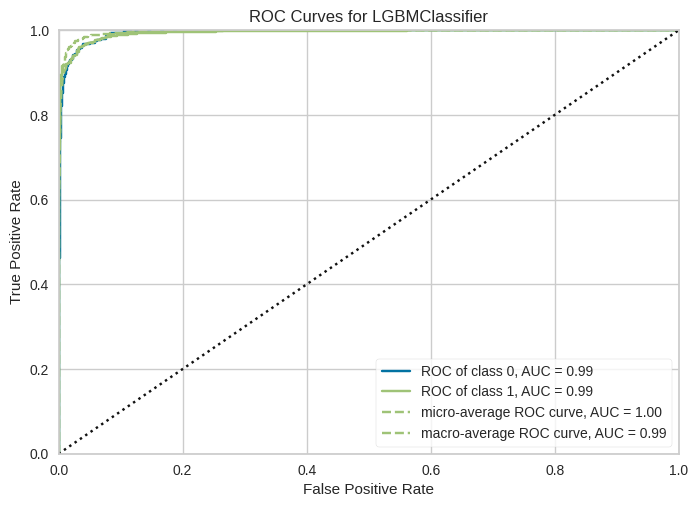

In [ ]:
# AUC Plot
plot_model(churn_lightgbm, plot = 'auc')

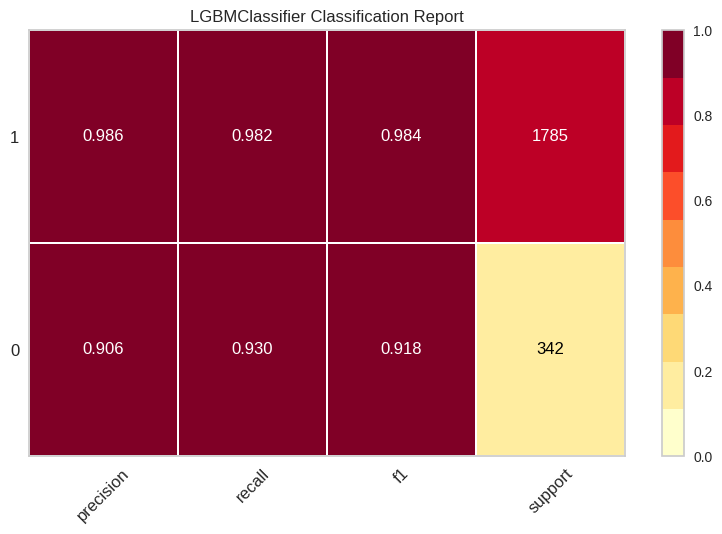

In [ ]:
# class report
plot_model(churn_lightgbm, plot = 'class_report')

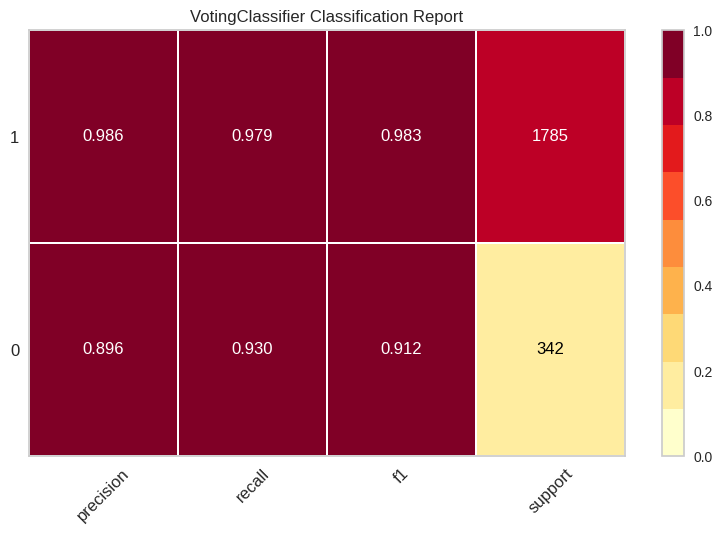

In [ ]:
# lets check it also for the combined/blended model
plot_model(churn_blended_top3, plot = 'class_report')

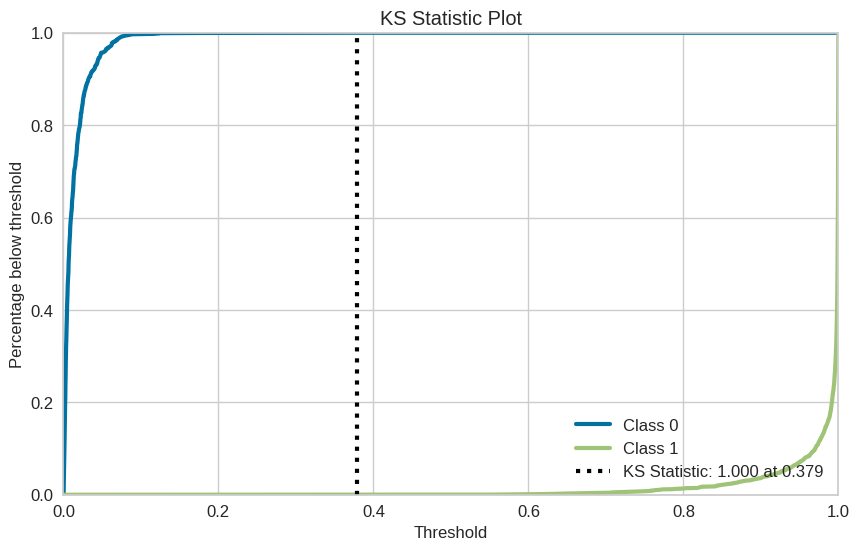

In [ ]:
# KS plot
plot_model(churn_lightgbm, plot = 'ks')

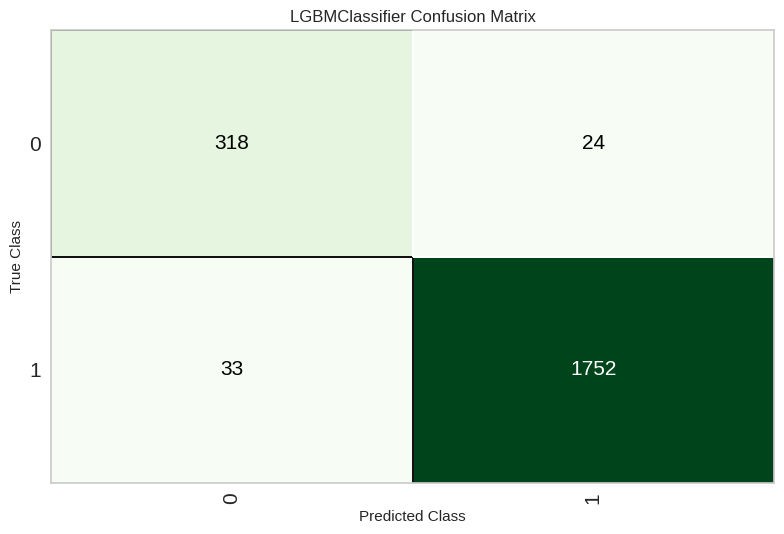

In [ ]:
# confusion matrix
plot_model(churn_lightgbm, plot = 'confusion_matrix')

# https://pycaret.gitbook.io/docs/get-started/functions/analyze

# full list of available plots by problem type is available e.g. here: https://pycaret.gitbook.io/docs/get-started/functions/analyze

# Model interpretation - XAI part

In [ ]:
# Permutation-based Feature Importance Plot
interpret_model(churn_lightgbm,
                plot = 'pfi')


36it [00:01, 22.81it/s]


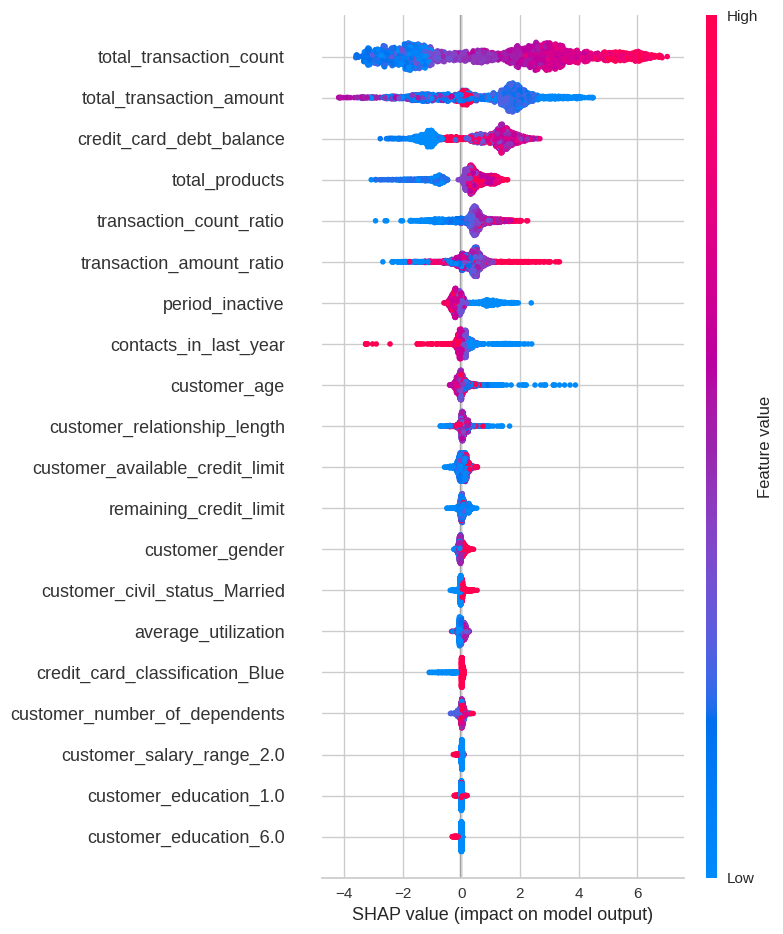

In [ ]:
# Interpret the model - an extended feature importance based on SHAP
interpret_model(churn_lightgbm,
                plot = 'summary') # default

# the optional argument save = True allows to save the plot in the current working directory
# (then it is not shown here)

In [ ]:
# Partial Dependency Profiles for selected features

interpret_model(churn_lightgbm,
                plot = 'pdp',
                feature = 'total_transaction_count')

# the blue line (Main) shows the averaged PDP over the whole sample

# “Background 1,” “Background 2,” etc. are references to different “subsets” used to compute the partial dependence.
# By comparing them, you see how partial dependence might vary across different regions of your data.

# If lines differ significantly, the model’s sensitivity to total_transaction_count is not uniform across all contexts;
# it depends on other variables in each background subset.

# The histogram below helps you see where the feature’s values fall in your data.

# more about PDP used here can be found here:
# https://github.com/SauceCat/PDPbox

In [ ]:
interpret_model(churn_lightgbm,
                plot = 'pdp',
                feature = 'customer_age')

Finalize Model for Deployment - The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [ ]:
final_churn_lightgbm = finalize_model(churn_lightgbm)

# Final model parameters for deployment
print(final_churn_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['customer_age',
                                             'customer_number_of_dependents',
                                             'customer_relationship_length',
                                             'customer_available_credit_limit',
                                             'total_products',
                                             'period_ina...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=

In [ ]:
# Saving the model - allows you to save the model along with entire transformation pipeline for later use.
save_model(final_churn_lightgbm, 'data/Final_churn_xgboost_2025-01-18')
# stores model as a .pkl file

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['customer_age',
                                              'customer_number_of_dependents',
                                              'customer_relationship_length',
                                              'customer_available_credit_limit',
                                              'total_products',
                                              'period_ina...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 mi

In [ ]:
# loading a previously saved model
final_churn_lightgbm_saved = load_model('data/Final_churn_xgboost_2025-01-18')

Transformation Pipeline and Model Successfully Loaded


## Prediction on a new dataset

In [ ]:
# make predictions on a new dataset

churn_test_forecast_lighgbm = predict_model(final_churn_lightgbm_saved,
                                            data = churn_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9628,0.9896,0.9628,0.9635,0.9631,0.8642,0.8644


In [ ]:
# lets compare it with the blended model performance on test data
churn_test_forecast_blended = predict_model(churn_blended_top3,
                                            data = churn_test)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9595,0,0.9595,0.9603,0.9598,0.8522,0.8524


Looks like combining the best model with two weaker makes the combined model performing slightly worse